In [34]:
import pandas
import seaborn
import sklearn
import functions as covid_lib
from numpy import hstack
from random import random
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
from dash.dependencies import Input, Output 

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense


---
## 1st Dataset : John Hopkins Data

In [2]:
## John Hopkins Center for Systems Science and Engineer Data Base URL
## Contains timeseries data
## This set of data is updated daily
baseURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

cumulated_confirmed_url = baseURL + "time_series_covid19_confirmed_global.csv"
cumulated_deaths_url    = baseURL + "time_series_covid19_deaths_global.csv"
cumulated_recovered_url = baseURL + "time_series_covid19_recovered_global.csv"

cumulated_confirmed     = pd.read_csv(cumulated_confirmed_url)
cumulated_deaths        = pd.read_csv(cumulated_deaths_url)
cumulated_recovered     = pd.read_csv(cumulated_recovered_url)

## Processed Dataset
## Combine by Country/Region
cumulated_confirmed_country = covid_lib.df_groupby_countries(cumulated_confirmed)
cumulated_deaths_country = covid_lib.df_groupby_countries(cumulated_deaths)
cumulated_recovered_country = covid_lib.df_groupby_countries(cumulated_recovered)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# US_confirmed.to_csv('cululated_confirmed.csv', index = False)

In [4]:
print("Confirmed data shape : " + str(cumulated_confirmed_country.shape))
print("Recovered data shape : " + str(cumulated_deaths_country.shape))
print("Deaths data shape : " + str(cumulated_recovered_country.shape))

Confirmed data shape : (188, 173)
Recovered data shape : (188, 173)
Deaths data shape : (188, 173)


In [5]:
# ## To find specific instances on certain countries
# ## Consider grouping by countries to simplify the analysis process
# cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="US"].head()

In [6]:
cumulated_confirmed_country.head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20
0,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,...,31517,31836,32022,32324,32672,32951,33190,33384,33594,33908
1,Albania,41.1533,20.1683,0,0,0,0,0,0,0,...,2535,2580,2662,2752,2819,2893,2964,3038,3106,3188
2,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,...,13907,14272,14657,15070,15500,15941,16404,16879,17348,17808
3,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,...,855,855,855,855,855,855,855,855,855,855
4,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,...,284,291,315,328,346,346,346,386,386,396


In [7]:
unique_countries = cumulated_confirmed_country["Country/Region"].unique()

In [8]:
cumulated_deaths_country[cumulated_deaths_country["Country/Region"]=="Taiwan*"]


,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20
165,Taiwan*,23.7,121.0,0,0,0,0,0,0,0,...,7,7,7,7,7,7,7,7,7,7


In [9]:
## Call this only if you wanna wait forever
proceed = False
if proceed:
    for country in unique_countries:
        covid_lib.plt_all_cases_increase_cases(country, cumulated_confirmed_country  )

In [10]:
# US_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="US"].head()
# US_confirmed

# all_cases, increased_case = covid_lib.df_to_timeseries(US_confirmed, 7)

In [11]:
query_country = "Taiwan*"
query_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]==query_country]
queried_total_cases, queried_increased_case = covid_lib.df_to_timeseries(query_confirmed, 1)
model = SARIMAX(queried_total_cases, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=False)
yhat = model_fit.predict(len(queried_total_cases), len(queried_total_cases)+10)
print(yhat)
covid_lib.plot_all( queried_total_cases, queried_increased_case, yhat , query_country )

[449.00013851 449.00020283 449.0002929  449.00037527 449.00045978
 449.00054372 449.00062781 449.00071186 449.00079591 449.00087997
 449.00096403]


### Taiwan Analysis

In [12]:
# TW_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="Taiwan*"].head()
# total_cases, increased_case = covid_lib.df_to_timeseries(TW_confirmed, 7)


### US Analysis

In [13]:
US_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="US"].head()
total_cases, increased_case = covid_lib.df_to_timeseries(US_confirmed, 7)


<IPython.core.display.Javascript object>

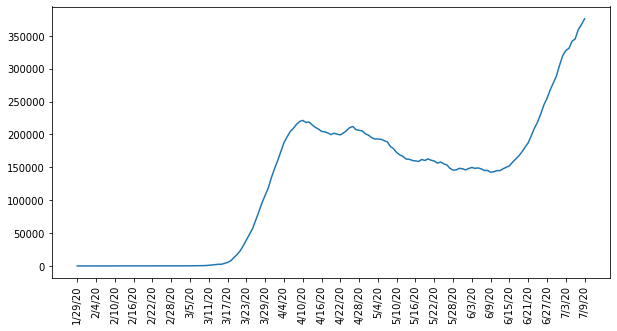

In [14]:
figure = plt.figure(figsize = (10,5))
plt.plot(increased_case)
plt.xticks(np.arange(0, len(increased_case.dropna()), 6)) 
plt.xticks(rotation=90)
plt.savefig("Infected Case.jpg",  bbox_inches='tight')

In [15]:
covid_lib.plot_all( total_cases, increased_case, yhat , "US" )

---

### Total Model Building

/home/mavericku/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/home/mavericku/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Test RMSE: 20.731


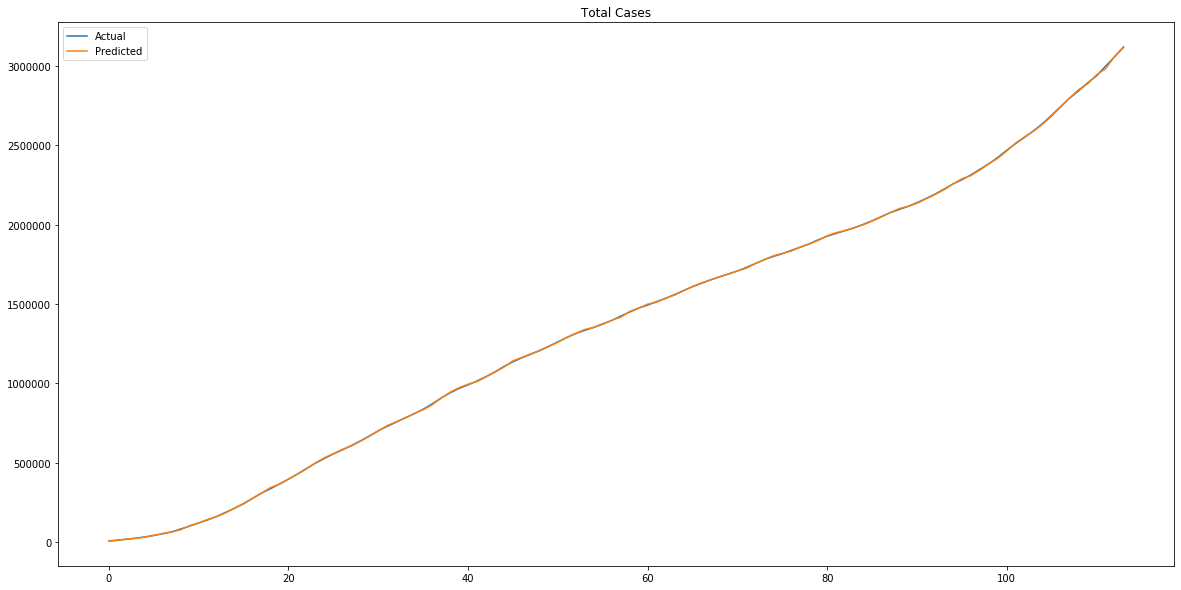

In [16]:
predictions_total, model_total = covid_lib.SARIMA_PREDICT(total_cases,"Total Cases", order_tuple = (0,1,0), fit_param = (True, True))

#### Predict future total Cases

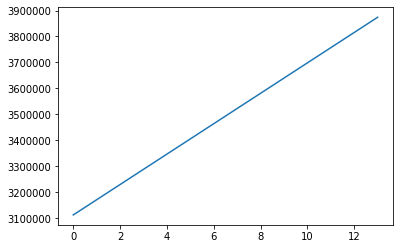

In [17]:
# today and tomorrow
temp = model_total.forecast(14)
plt.plot(temp)

---

#### Increase Model Building

/home/mavericku/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



Test RMSE: 17.577


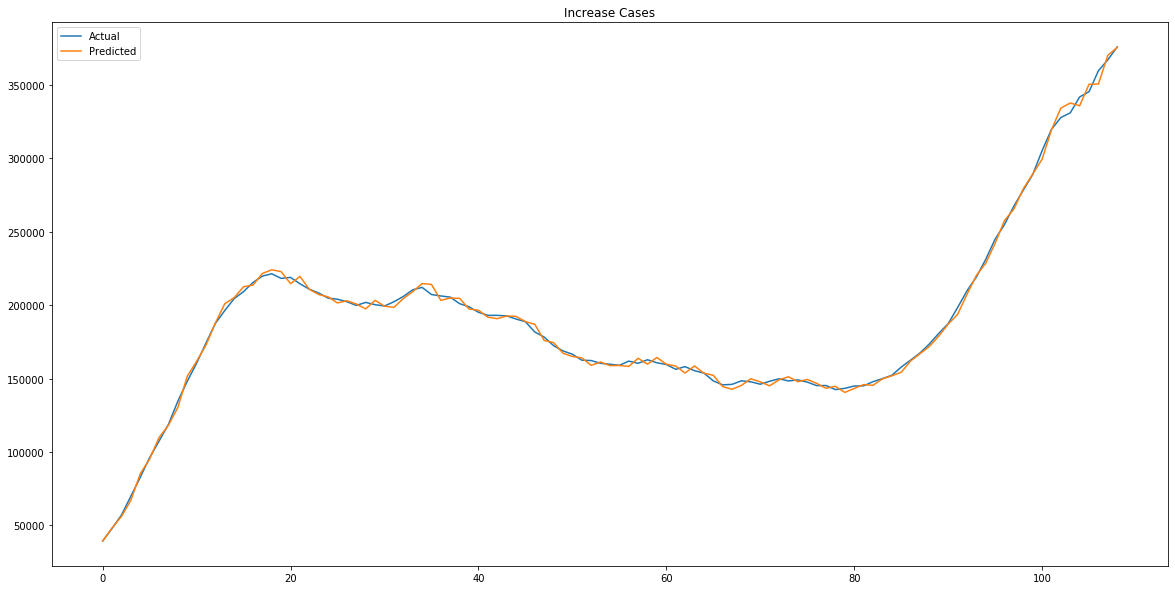

In [18]:
increase_temp = increased_case.values 
predictions_increase, model_increase = covid_lib.SARIMA_PREDICT(increase_temp, "Increase Cases",  is_increase_case = True, fit_param = (True,True) )

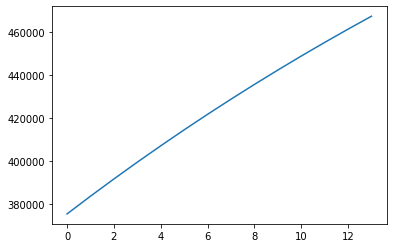

In [19]:
# today and tomorrow
temp = model_increase.forecast(14)
plt.plot(temp)

---

In [20]:
from numpy import array
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x) 
        y.append(seq_y)
    return array(X), array(y)

In [21]:
def train_test_split_timeseries(week_feature, week_target):
    feature_train = week_feature[:-8]
    target_train  = week_target[:-8]
    feature_test  = week_feature[-8:-1]
    target_test   = week_target[-8: -1]
    return   feature_train, target_train , feature_test , target_test  
    

In [22]:
one_week_feature, one_week_target = split_sequence(total_cases.transpose()[0], 7)
two_week_feature, two_week_target = split_sequence(total_cases.transpose()[0], 14)

In [27]:
train_owf, train_owt, test_owf, test_owt = train_test_split_timeseries(one_week_feature, one_week_target)

In [350]:
def LSTM_PREDICT(feature, target , test_feature, test_target , n_features, n_steps):
    from math import sqrt
    from sklearn.metrics import mean_squared_error
    feature = feature.reshape((feature.shape[0], feature.shape[1], n_features)) 
    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features),  return_sequences=True, ))
    model.add(LSTM(50, activation='relu'))    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # fit model
    model.fit(feature, target , epochs=200, verbose=0)
    
    predicted = []
    
    for i in range(0 , len(test_target)):
        
        # demonstrate prediction  
        test_input = test_feature[i].reshape((1, n_steps, n_features)) 
        yhat = model.predict(test_input, verbose=0) 
        predicted.append(np.array(yhat)[0])
        
    rmse = sqrt(mean_squared_error(test_target, predicted))   / len(test_target)
    
    plt.plot(test_target)
    plt.plot(predicted)
    plt.legend(["real" , "predicted"])
#     plt.savefig("Standard  LSTM Only Model.png")
    return rmse

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4360.343554854706

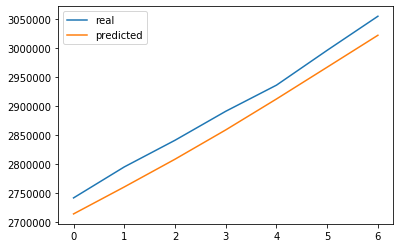

In [352]:

LSTM_PREDICT(feature = train_owf,
     target = train_owt, 
     test_feature = test_owf,
     test_target = test_owt ,
     n_features = 1,
     n_steps = 7)

In [345]:
in_seq1 = array([
        228547.34414895,
        237673.03226072, 
        246521.73465596, 
        255101.85849107,
        263421.55574582, 
        271488.73096857, 
        279311.04878637, 
        286895.94118714,
        294250.61458078, 
        301382.05664602, 
        308297.0429694 , 
        315002.14348272,
        321503.72870522, 
        327807.97579613])

in_seq2 = array([0, 0, 0, 2, 2, 0, -1, -1, 0 ,0, 0, 0, 0, 0])

out_seq = array([
       231200,
       244975,
       254932,
       267528,
       278366,
       288923,
       305162,
       319750,
       327807,
       330982,
       341830,
       345409,
       359684,
       367111])

test_input = [[228547, 0],
 [237673, 0],
 [246521, 0],
 [255101, 2],
 [263421, 2],
 [271488, 0],
 [279311, 0],
 [286895, 1],
 [294250, 1],
 [301382, 1],
 [308297, 0],
 [315002, 0],
 [321503, 0],
 [327807, 0]]


In [346]:
test_x =  array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))]) 

In [347]:


    
# define input sequence
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))

# choose a number of time steps
n_steps = 7

# convert into input/output
# print(dataset)
X, y = split_sequences(dataset, n_steps) 
n_features = X.shape[2]

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model 
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction 


lstm_predictions = []
for i in range(0 , len(testtt)-7):
    lstm_predictions.append(testtt[i][0])
    
for i in range(0 , len(test_input)-7):
    test_input_segment = array(test_input[i:i+7]) 
    x_input = test_input_segment.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    print(yhat)
    lstm_predictions.append(yhat[0][0])

[[303563.25]]
[[314235.03]]
[[324582.66]]
[[334616.3]]
[[344345.88]]
[[353780.25]]
[[362927.9]]


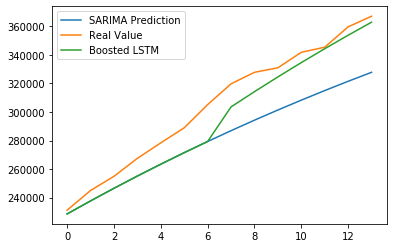

In [348]:
plt.plot(in_seq1_ar)
plt.plot(out_seq)
plt.plot(lstm_predictions)
plt.legend(["SARIMA Prediction" , "Real Value" , "Boosted LSTM"])
# plt.savefig("BoostedLSTMDay7.png")